In [1]:
from __future__ import print_function

In [2]:
pip install vit-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 3.0 MB/s 


In [3]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import glob
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt

from itertools import chain
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from vit_pytorch.cvt import CvT

In [6]:
# Training settings
batch_size = 64
epochs = 200
lr = 0.00001
gamma = 0.7
seed = 42

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [8]:
'''
IMAGE CATEGORY ENCODING

Benign = 0
Malignant = 1
'''

'\nIMAGE CATEGORY ENCODING\n\nBenign = 0\nMalignant = 1\n'

In [9]:
from google.colab import drive
drive.mount('/content/drive')

train_list = glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10253', '*', '*.png'))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10254', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10255', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10256', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10257', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10258', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10259', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10260', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10261', '*', '*.png')))
train_list.extend(glob.glob(os.path.join('/content/drive/MyDrive/IDCDataset/10264', '*', '*.png')))

print(f"Train list length: {len(train_list)}")

Mounted at /content/drive
Train list length: 7906


In [10]:
random.shuffle(train_list)

In [11]:
train_list, test_list = train_test_split(train_list,
                                          test_size=0.15,
                                          random_state=42)

In [12]:
test_list, valid_list = train_test_split(test_list,
                                          test_size=0.33,
                                          random_state=42)

In [13]:
print(f"Train Data: {len(train_list)}")
print(f"Valid Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 6720
Valid Data: 392
Test Data: 794


In [14]:
device = 'cuda'

In [15]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.ToTensor(),
    ]
)

valid_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

In [16]:
class IDCDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-2].split(".")[0]
        label = 1 if label == "1" else 0

        return img_transformed, label

In [17]:
train_data = IDCDataset(train_list, transform=train_transforms)
valid_data = IDCDataset(valid_list, transform=valid_transforms)
test_data = IDCDataset(test_list, transform=test_transforms)

In [18]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [19]:
model = CvT(
    num_classes = 2,

    s1_emb_dim = 64,        # stage 1 - dimension
    s1_emb_kernel = 7,      # stage 1 - conv kernel
    s1_emb_stride = 4,      # stage 1 - conv stride
    s1_proj_kernel = 3,     # stage 1 - attention ds-conv kernel size
    s1_kv_proj_stride = 2,  # stage 1 - attention key / value projection stride
    s1_heads = 1,           # stage 1 - heads
    s1_depth = 1,           # stage 1 - depth
    s1_mlp_mult = 4,        # stage 1 - feedforward expansion factor

    s2_emb_dim = 192,       # stage 2 - (same as above)
    s2_emb_kernel = 3,
    s2_emb_stride = 2,
    s2_proj_kernel = 3,
    s2_kv_proj_stride = 2,
    s2_heads = 3,
    s2_depth = 2,
    s2_mlp_mult = 4,

    s3_emb_dim = 384,       # stage 3 - (same as above)
    s3_emb_kernel = 3,
    s3_emb_stride = 2,
    s3_proj_kernel = 3,
    s3_kv_proj_stride = 2,
    s3_heads = 4,
    s3_depth = 10,
    s3_mlp_mult = 4,

    dropout = 0.1
).to(device)

In [20]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [21]:
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

bestloss = 100
patience = 15
triggers = 0

In [22]:
model.load_state_dict(torch.load("/content/drive/MyDrive/SavedViTModels/CvTSavedModel2.pth"))

<All keys matched successfully>

In [23]:
start_time = time.time()

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    model.train()
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss.item() / len(train_loader)

    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss.item() / len(valid_loader)
    
    train_loss_list.append(epoch_loss)
    train_accuracy_list.append(epoch_accuracy)
    val_loss_list.append(epoch_val_loss)
    val_accuracy_list.append(epoch_val_accuracy)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    if(epoch_loss < bestloss):
        triggers = 0
        bestloss = epoch_loss
        #torch.save(model.state_dict(), "/content/drive/MyDrive/SavedViTModels/CvTSavedModel2.pth")
        #torch.save(optimizer.state_dict(), "/content/drive/MyDrive/SavedViTModels/CvTSavedOptimizer2.pth")
    else:
        triggers += 1

    if triggers == patience:
        print("Early stopping since epoch_loss > bestloss for 15 epochs")
        break

end_time = time.time()

print(f"\nTime taken to train the model: {(end_time - start_time)/60/60} hours")

100%|██████████| 105/105 [1:18:50<00:00, 45.06s/it]


Epoch : 1 - loss : 0.5073 - acc: 0.7740 - val_loss : 0.4221 - val_acc: 0.8192



100%|██████████| 105/105 [01:56<00:00,  1.11s/it]


Epoch : 2 - loss : 0.3859 - acc: 0.8314 - val_loss : 0.4138 - val_acc: 0.8080



100%|██████████| 105/105 [01:56<00:00,  1.11s/it]


Epoch : 3 - loss : 0.3662 - acc: 0.8467 - val_loss : 0.3392 - val_acc: 0.8415



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 4 - loss : 0.3622 - acc: 0.8427 - val_loss : 0.3003 - val_acc: 0.8817



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 5 - loss : 0.3541 - acc: 0.8497 - val_loss : 0.3648 - val_acc: 0.8438



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 6 - loss : 0.3426 - acc: 0.8551 - val_loss : 0.3528 - val_acc: 0.8683



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 7 - loss : 0.3332 - acc: 0.8570 - val_loss : 0.2947 - val_acc: 0.8728



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 8 - loss : 0.3318 - acc: 0.8558 - val_loss : 0.2880 - val_acc: 0.8906



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 9 - loss : 0.3307 - acc: 0.8604 - val_loss : 0.3724 - val_acc: 0.8147



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 10 - loss : 0.3263 - acc: 0.8561 - val_loss : 0.3542 - val_acc: 0.8415



100%|██████████| 105/105 [01:56<00:00,  1.11s/it]


Epoch : 11 - loss : 0.3150 - acc: 0.8629 - val_loss : 0.2586 - val_acc: 0.8862



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 12 - loss : 0.3128 - acc: 0.8671 - val_loss : 0.2689 - val_acc: 0.8929



100%|██████████| 105/105 [01:56<00:00,  1.11s/it]


Epoch : 13 - loss : 0.3122 - acc: 0.8618 - val_loss : 0.4372 - val_acc: 0.8192



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 14 - loss : 0.3094 - acc: 0.8649 - val_loss : 0.3148 - val_acc: 0.8571



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 15 - loss : 0.3132 - acc: 0.8653 - val_loss : 0.2971 - val_acc: 0.8616



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 16 - loss : 0.3074 - acc: 0.8707 - val_loss : 0.3413 - val_acc: 0.8661



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 17 - loss : 0.3013 - acc: 0.8729 - val_loss : 0.3055 - val_acc: 0.8750



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 18 - loss : 0.2966 - acc: 0.8751 - val_loss : 0.2538 - val_acc: 0.9063



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 19 - loss : 0.2931 - acc: 0.8741 - val_loss : 0.2491 - val_acc: 0.8929



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 20 - loss : 0.2968 - acc: 0.8689 - val_loss : 0.4102 - val_acc: 0.8125



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 21 - loss : 0.3000 - acc: 0.8704 - val_loss : 0.3285 - val_acc: 0.8661



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 22 - loss : 0.2906 - acc: 0.8756 - val_loss : 0.3652 - val_acc: 0.8594



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 23 - loss : 0.2941 - acc: 0.8746 - val_loss : 0.2414 - val_acc: 0.9040



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 24 - loss : 0.2940 - acc: 0.8744 - val_loss : 0.2867 - val_acc: 0.8661



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 25 - loss : 0.2874 - acc: 0.8762 - val_loss : 0.2615 - val_acc: 0.8772



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 26 - loss : 0.2844 - acc: 0.8780 - val_loss : 0.2395 - val_acc: 0.8929



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 27 - loss : 0.2915 - acc: 0.8763 - val_loss : 0.2204 - val_acc: 0.9129



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 28 - loss : 0.2783 - acc: 0.8857 - val_loss : 0.3765 - val_acc: 0.8170



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 29 - loss : 0.2855 - acc: 0.8826 - val_loss : 0.3289 - val_acc: 0.8817



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 30 - loss : 0.2785 - acc: 0.8813 - val_loss : 0.2731 - val_acc: 0.8750



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 31 - loss : 0.2766 - acc: 0.8815 - val_loss : 0.2620 - val_acc: 0.8772



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 32 - loss : 0.2742 - acc: 0.8841 - val_loss : 0.2345 - val_acc: 0.9018



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 33 - loss : 0.2763 - acc: 0.8853 - val_loss : 0.2542 - val_acc: 0.8772



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 34 - loss : 0.2756 - acc: 0.8823 - val_loss : 0.2417 - val_acc: 0.9085



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 35 - loss : 0.2798 - acc: 0.8832 - val_loss : 0.2765 - val_acc: 0.8906



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 36 - loss : 0.2762 - acc: 0.8872 - val_loss : 0.2738 - val_acc: 0.8951



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 37 - loss : 0.2759 - acc: 0.8865 - val_loss : 0.2651 - val_acc: 0.8973



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 38 - loss : 0.2719 - acc: 0.8851 - val_loss : 0.2651 - val_acc: 0.8839



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 39 - loss : 0.2761 - acc: 0.8829 - val_loss : 0.3056 - val_acc: 0.8772



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 40 - loss : 0.2685 - acc: 0.8882 - val_loss : 0.2239 - val_acc: 0.9174



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 41 - loss : 0.2713 - acc: 0.8850 - val_loss : 0.2595 - val_acc: 0.8839



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 42 - loss : 0.2757 - acc: 0.8832 - val_loss : 0.2311 - val_acc: 0.9107



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 43 - loss : 0.2676 - acc: 0.8866 - val_loss : 0.2498 - val_acc: 0.8906



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 44 - loss : 0.2669 - acc: 0.8869 - val_loss : 0.2527 - val_acc: 0.8906



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 45 - loss : 0.2721 - acc: 0.8832 - val_loss : 0.2550 - val_acc: 0.9085



100%|██████████| 105/105 [01:54<00:00,  1.10s/it]


Epoch : 46 - loss : 0.2634 - acc: 0.8912 - val_loss : 0.2312 - val_acc: 0.9040



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 47 - loss : 0.2630 - acc: 0.8908 - val_loss : 0.2418 - val_acc: 0.8973



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 48 - loss : 0.2680 - acc: 0.8836 - val_loss : 0.2399 - val_acc: 0.8884



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 49 - loss : 0.2647 - acc: 0.8869 - val_loss : 0.2666 - val_acc: 0.8817



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 50 - loss : 0.2639 - acc: 0.8888 - val_loss : 0.2605 - val_acc: 0.9062



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 51 - loss : 0.2636 - acc: 0.8894 - val_loss : 0.2655 - val_acc: 0.8750



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 52 - loss : 0.2664 - acc: 0.8865 - val_loss : 0.2895 - val_acc: 0.8683



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 53 - loss : 0.2672 - acc: 0.8844 - val_loss : 0.2655 - val_acc: 0.8951



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 54 - loss : 0.2648 - acc: 0.8863 - val_loss : 0.2966 - val_acc: 0.9040



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 55 - loss : 0.2636 - acc: 0.8872 - val_loss : 0.2329 - val_acc: 0.9107



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 56 - loss : 0.2644 - acc: 0.8894 - val_loss : 0.3061 - val_acc: 0.8661



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 57 - loss : 0.2556 - acc: 0.8912 - val_loss : 0.2564 - val_acc: 0.8839



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 58 - loss : 0.2582 - acc: 0.8906 - val_loss : 0.2222 - val_acc: 0.9040



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 59 - loss : 0.2509 - acc: 0.8960 - val_loss : 0.2979 - val_acc: 0.8304



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 60 - loss : 0.2557 - acc: 0.8900 - val_loss : 0.2600 - val_acc: 0.8929



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 61 - loss : 0.2605 - acc: 0.8914 - val_loss : 0.2789 - val_acc: 0.8973



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 62 - loss : 0.2564 - acc: 0.8891 - val_loss : 0.2358 - val_acc: 0.9085



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 63 - loss : 0.2538 - acc: 0.8964 - val_loss : 0.2264 - val_acc: 0.9018



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 64 - loss : 0.2518 - acc: 0.8924 - val_loss : 0.2278 - val_acc: 0.9085



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 65 - loss : 0.2585 - acc: 0.8914 - val_loss : 0.2199 - val_acc: 0.9196



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 66 - loss : 0.2533 - acc: 0.8990 - val_loss : 0.2879 - val_acc: 0.8571



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 67 - loss : 0.2486 - acc: 0.8975 - val_loss : 0.3536 - val_acc: 0.8504



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 68 - loss : 0.2544 - acc: 0.8868 - val_loss : 0.3238 - val_acc: 0.8438



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 69 - loss : 0.2536 - acc: 0.8929 - val_loss : 0.2279 - val_acc: 0.9063



100%|██████████| 105/105 [01:56<00:00,  1.11s/it]


Epoch : 70 - loss : 0.2540 - acc: 0.8961 - val_loss : 0.2473 - val_acc: 0.8996



100%|██████████| 105/105 [01:56<00:00,  1.11s/it]


Epoch : 71 - loss : 0.2511 - acc: 0.8921 - val_loss : 0.2536 - val_acc: 0.8795



100%|██████████| 105/105 [01:56<00:00,  1.11s/it]


Epoch : 72 - loss : 0.2525 - acc: 0.8969 - val_loss : 0.2438 - val_acc: 0.8906



100%|██████████| 105/105 [01:56<00:00,  1.11s/it]


Epoch : 73 - loss : 0.2483 - acc: 0.8920 - val_loss : 0.2269 - val_acc: 0.8996



100%|██████████| 105/105 [01:56<00:00,  1.11s/it]


Epoch : 74 - loss : 0.2475 - acc: 0.8960 - val_loss : 0.2411 - val_acc: 0.8839



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 75 - loss : 0.2455 - acc: 0.8949 - val_loss : 0.2376 - val_acc: 0.9174



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 76 - loss : 0.2462 - acc: 0.8967 - val_loss : 0.2315 - val_acc: 0.8951



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 77 - loss : 0.2476 - acc: 0.8999 - val_loss : 0.2426 - val_acc: 0.9040



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 78 - loss : 0.2473 - acc: 0.8945 - val_loss : 0.2301 - val_acc: 0.9040



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 79 - loss : 0.2472 - acc: 0.8978 - val_loss : 0.2690 - val_acc: 0.8817



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 80 - loss : 0.2472 - acc: 0.8957 - val_loss : 0.2494 - val_acc: 0.8906



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 81 - loss : 0.2465 - acc: 0.8993 - val_loss : 0.2891 - val_acc: 0.8862



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 82 - loss : 0.2435 - acc: 0.8955 - val_loss : 0.2274 - val_acc: 0.9040



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 83 - loss : 0.2454 - acc: 0.8999 - val_loss : 0.2236 - val_acc: 0.9040



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 84 - loss : 0.2457 - acc: 0.8978 - val_loss : 0.2762 - val_acc: 0.8772



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 85 - loss : 0.2461 - acc: 0.8999 - val_loss : 0.2950 - val_acc: 0.8750



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 86 - loss : 0.2413 - acc: 0.9015 - val_loss : 0.4002 - val_acc: 0.8772



100%|██████████| 105/105 [01:56<00:00,  1.11s/it]


Epoch : 87 - loss : 0.2459 - acc: 0.8955 - val_loss : 0.2558 - val_acc: 0.8929



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 88 - loss : 0.2498 - acc: 0.8923 - val_loss : 0.2883 - val_acc: 0.8996



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 89 - loss : 0.2401 - acc: 0.8958 - val_loss : 0.2153 - val_acc: 0.9085



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 90 - loss : 0.2456 - acc: 0.8972 - val_loss : 0.2267 - val_acc: 0.8996



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 91 - loss : 0.2410 - acc: 0.9009 - val_loss : 0.2253 - val_acc: 0.8996



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 92 - loss : 0.2456 - acc: 0.8982 - val_loss : 0.2243 - val_acc: 0.9018



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 93 - loss : 0.2396 - acc: 0.8954 - val_loss : 0.2589 - val_acc: 0.8929



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 94 - loss : 0.2496 - acc: 0.8926 - val_loss : 0.2207 - val_acc: 0.9040



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 95 - loss : 0.2441 - acc: 0.8969 - val_loss : 0.2834 - val_acc: 0.8705



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 96 - loss : 0.2466 - acc: 0.8938 - val_loss : 0.2417 - val_acc: 0.8772



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 97 - loss : 0.2389 - acc: 0.9004 - val_loss : 0.2496 - val_acc: 0.8973



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 98 - loss : 0.2447 - acc: 0.8985 - val_loss : 0.2348 - val_acc: 0.8951



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 99 - loss : 0.2386 - acc: 0.8988 - val_loss : 0.2338 - val_acc: 0.8996



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 100 - loss : 0.2378 - acc: 0.8975 - val_loss : 0.3061 - val_acc: 0.8951



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 101 - loss : 0.2406 - acc: 0.8990 - val_loss : 0.2309 - val_acc: 0.8951



100%|██████████| 105/105 [01:54<00:00,  1.10s/it]


Epoch : 102 - loss : 0.2362 - acc: 0.9012 - val_loss : 0.3594 - val_acc: 0.8772



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 103 - loss : 0.2343 - acc: 0.9040 - val_loss : 0.2348 - val_acc: 0.8906



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 104 - loss : 0.2409 - acc: 0.8996 - val_loss : 0.2181 - val_acc: 0.9375



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 105 - loss : 0.2354 - acc: 0.9004 - val_loss : 0.2218 - val_acc: 0.9174



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 106 - loss : 0.2337 - acc: 0.9031 - val_loss : 0.2310 - val_acc: 0.9129



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 107 - loss : 0.2377 - acc: 0.9022 - val_loss : 0.2681 - val_acc: 0.8973



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 108 - loss : 0.2395 - acc: 0.8954 - val_loss : 0.2183 - val_acc: 0.9107



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 109 - loss : 0.2348 - acc: 0.9012 - val_loss : 0.2509 - val_acc: 0.8996



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 110 - loss : 0.2340 - acc: 0.9010 - val_loss : 0.2449 - val_acc: 0.8951



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 111 - loss : 0.2275 - acc: 0.9003 - val_loss : 0.2101 - val_acc: 0.9196



100%|██████████| 105/105 [01:56<00:00,  1.11s/it]


Epoch : 112 - loss : 0.2349 - acc: 0.9031 - val_loss : 0.2215 - val_acc: 0.9196



100%|██████████| 105/105 [01:56<00:00,  1.10s/it]


Epoch : 113 - loss : 0.2363 - acc: 0.9004 - val_loss : 0.2664 - val_acc: 0.8862



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 114 - loss : 0.2336 - acc: 0.9065 - val_loss : 0.2215 - val_acc: 0.9107



100%|██████████| 105/105 [01:56<00:00,  1.11s/it]


Epoch : 115 - loss : 0.2336 - acc: 0.9028 - val_loss : 0.2203 - val_acc: 0.9152



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 116 - loss : 0.2359 - acc: 0.8991 - val_loss : 0.2691 - val_acc: 0.8772



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 117 - loss : 0.2407 - acc: 0.9024 - val_loss : 0.2476 - val_acc: 0.8973



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 118 - loss : 0.2316 - acc: 0.9063 - val_loss : 0.2683 - val_acc: 0.8862



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 119 - loss : 0.2328 - acc: 0.9037 - val_loss : 0.2681 - val_acc: 0.9040



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 120 - loss : 0.2338 - acc: 0.9042 - val_loss : 0.2487 - val_acc: 0.8906



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 121 - loss : 0.2336 - acc: 0.9033 - val_loss : 0.2213 - val_acc: 0.9040



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 122 - loss : 0.2282 - acc: 0.9051 - val_loss : 0.2784 - val_acc: 0.8728



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 123 - loss : 0.2379 - acc: 0.8987 - val_loss : 0.2101 - val_acc: 0.9129



100%|██████████| 105/105 [01:54<00:00,  1.09s/it]


Epoch : 124 - loss : 0.2374 - acc: 0.9003 - val_loss : 0.1981 - val_acc: 0.9263



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 125 - loss : 0.2315 - acc: 0.9039 - val_loss : 0.2137 - val_acc: 0.9085



100%|██████████| 105/105 [01:55<00:00,  1.10s/it]


Epoch : 126 - loss : 0.2338 - acc: 0.9009 - val_loss : 0.2644 - val_acc: 0.8817

Early stopping since epoch_loss > bestloss for 15 epochs

Time taken to train the model: 5.463536028464635 hours


In [24]:
print("train_loss: ")
print(np.asarray(torch.Tensor(train_loss_list).cpu()))
print("train_acc: ")
print(np.asarray(torch.Tensor(train_accuracy_list).cpu()))
print("val_loss: ")
print(np.asarray(torch.Tensor(val_loss_list).cpu()))
print("val_acc: ")
print(np.asarray(torch.Tensor(val_accuracy_list).cpu()))

train_loss: 
[0.5072642  0.38591543 0.3662122  0.3622305  0.35409814 0.34255844
 0.3331753  0.33175218 0.33074084 0.3263153  0.31500658 0.31283116
 0.31220123 0.30941686 0.31321397 0.3074176  0.30126837 0.2965778
 0.29310063 0.29675928 0.299976   0.29062036 0.29412457 0.2939919
 0.28736326 0.28440166 0.29145247 0.27834696 0.28545466 0.27853262
 0.2766083  0.27415338 0.2763383  0.27560213 0.27975795 0.27616146
 0.275941   0.27194715 0.276122   0.26846966 0.271317   0.2756592
 0.267624   0.2668571  0.27208197 0.26338774 0.26296666 0.26801923
 0.2647056  0.2639397  0.26357368 0.2663975  0.26719785 0.2648393
 0.26363918 0.2643828  0.2556132  0.258247   0.250905   0.255723
 0.26052475 0.25643173 0.25381964 0.25179696 0.25848106 0.25330356
 0.24858037 0.25435528 0.253632   0.2540336  0.2510547  0.25254187
 0.24832045 0.2474596  0.24552733 0.24616921 0.24756049 0.24734294
 0.24721873 0.24719374 0.24647523 0.24348855 0.2453866  0.24566521
 0.24608135 0.24126565 0.24594052 0.2497681  0.24012218

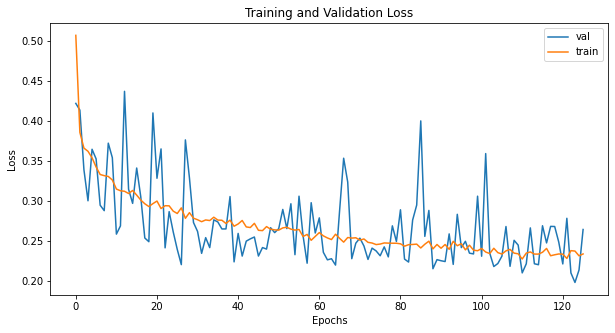

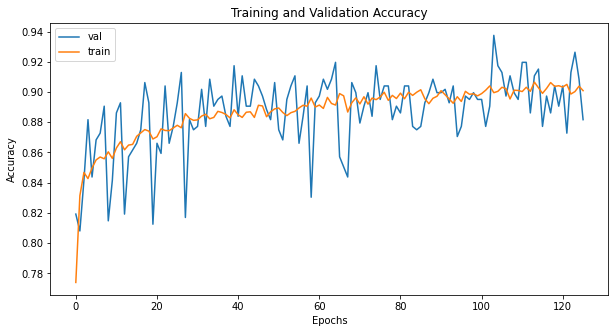

In [25]:
#Checking for overfitting/underfitting
val_loss_list = torch.from_numpy(np.asarray(torch.Tensor(val_loss_list).cpu()))
train_loss_list = torch.from_numpy(np.asarray(torch.Tensor(train_loss_list).cpu()))
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_loss_list,label="val")
plt.plot(train_loss_list,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

val_accuracy_list = torch.from_numpy(np.asarray(torch.Tensor(val_accuracy_list).cpu()))
train_accuracy_list = torch.from_numpy(np.asarray(torch.Tensor(train_accuracy_list).cpu()))
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accuracy_list,label="val")
plt.plot(train_accuracy_list,label="train")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [26]:
actual_labels = []
predicted_labels = []

In [27]:
#Test accuracy
model.eval()
with torch.no_grad():
        test_accuracy = []
        
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)
            
            actual_labels.extend(np.asarray(label.cpu()).tolist())

            t_output = model(data)
            t_loss = criterion(t_output, label)
            
            predicted_labels.extend(np.asarray(t_output.argmax(dim=1).cpu()).tolist())

            acc = (t_output.argmax(dim=1) == label).float().mean()
            test_accuracy.append(acc)

        final_test_accuracy = sum(test_accuracy)/len(test_accuracy)
        print(f"test_acc : {final_test_accuracy:.4f}\n")

test_acc : 0.9141



In [28]:
print("Actual labels: ")
print(actual_labels)
print("Predicted labels: ")
print(predicted_labels)

Actual labels: 
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in the model = {count_parameters(model)}")

Number of trainable parameters in the model = 17585986


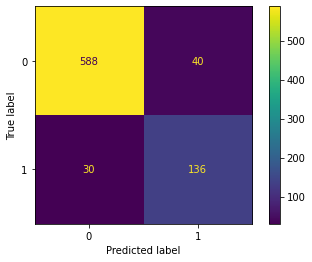

In [30]:
#Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

cnf_matrix = confusion_matrix(actual_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)

disp.plot()
plt.show()

In [31]:
#Specificity
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - cnf_matrix.sum(axis=0) - cnf_matrix.sum(axis=1) + np.diag(cnf_matrix)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

TNR = TN/(TN+FP)

print(f"Class wise specificity:")
print(f"Specificity = {TNR}\n")

print(f"Average specificity:")
print(f"Specificity = {np.average(np.array(TNR))}\n")

Class wise specificity:
Specificity = [0.81927711 0.93630573]

Average specificity:
Specificity = 0.8777914204589057



In [32]:
#Accuracy, Sensitivity, Precision, F1 score
from sklearn.metrics import classification_report

target_names = ['0', '1']
print(classification_report(actual_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       628
           1       0.77      0.82      0.80       166

    accuracy                           0.91       794
   macro avg       0.86      0.88      0.87       794
weighted avg       0.91      0.91      0.91       794



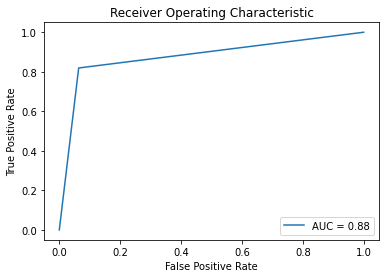

In [33]:
#ROC curve
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(actual_labels, predicted_labels)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [34]:
#AUC
print(f"AUC = {roc_auc}")

AUC = 0.8777914204589057
